## Quantum Simulation of the $H_2$ Molecule

### 1. Molecular Hamiltonian:

The Hamiltonian for the $H_2$ molecule comprises the kinetic energy of the electrons, the potential energies due to electron-nuclear interactions, and the electron-electron interactions:

$ \hat{H} = \sum_{i,j} t_{ij} a_i^\dagger a_j + \frac{1}{2} \sum_{i,j,k,l} V_{ijkl} a_i^\dagger a_j^\dagger a_k a_l $

Where:
- $ a_i^\dagger $ and $ a_i $ represent the fermionic creation and annihilation operators, respectively.
- $ t_{ij} $ and $ V_{ijkl} $ are the one-electron and two-electron integrals.

### 2. Mapping to Qubits:

For quantum computations, the fermionic Hamiltonian needs to be translated into a qubit Hamiltonian. The Jordan-Wigner transformation is commonly used, where each fermionic mode corresponds to a qubit:

$ a_j = \frac{1}{2} (X_j + i Y_j) \prod_{k=1}^{j-1} Z_k $

Applying this transformation, the molecular Hamiltonian is expressed as a sum of tensor products of Pauli matrices (X, Y, Z).


In [333]:
import qiskit as qk
from qiskit_nature import settings
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms.optimizers import COBYLA
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit.quantum_info import Statevector
from qiskit.primitives import Estimator
from qiskit.algorithms.time_evolvers import TimeEvolutionProblem, TrotterQRTE
from qiskit.synthesis import SuzukiTrotter
from qiskit_nature.operators.second_quantization import FermionicOp

import numpy as np
import matplotlib.pyplot as plt

settings.use_pauli_sum_op = False

## Quantum Simulation of $H_2$ Molecule using Qiskit

### 1. **Defining the Molecule**:
- Utilize Qiskit's `PySCFDriver` to define the $H_2$ molecule.

### 2. **Hamiltonian Transformation**:
- The electronic structure of the $H_2$ molecule is initially described in terms of fermionic creation and annihilation operators.
- Transform this fermionic Hamiltonian into a qubit (spin) Hamiltonian suitable for quantum computation.
- Two common transformations are:
  - **Jordan-Wigner Transformation**: Provides a direct mapping of fermions to qubits.
    - $ a_j \rightarrow \frac{1}{2} (X_j + i Y_j) \prod_{k=1}^{j-1} Z_k $
    - $ a_j^\dagger \rightarrow \frac{1}{2} (X_j - i Y_j) \prod_{k=1}^{j-1} Z_k $
  - **Bravyi-Kitaev Transformation**: A more efficient mapping especially for systems with local interactions, but is more complex in form.

### 3. **Quantum Algorithms**:
- With the qubit Hamiltonian in hand, employ quantum algorithms like the Variational Quantum Eigensolver (VQE) to estimate the ground state energy of the $H_2$ molecule.


In [334]:
driver = PySCFDriver(atom='H .0 .0 .0; H .0 .0 0.735', basis='sto3g')# H2 molecule with bond length 0.735 angstrom
molecule = driver.run() 

In [335]:
mapper = JordanWignerMapper()

In [336]:
# Now we get the second quantized Hamiltonian
hamiltonian = molecule.hamiltonian.second_q_op()
# By obtaining this Hamiltonian in the second quantized form, we are then set up to transform it into a qubit representation
h2_hamiltonian = mapper.map(hamiltonian)


**Determine the HF Configuration:** 
   For a molecule like $H_2$, the HF ground state may be represented as $|1s_1 1s_0 \rangle$, where $1s_1$ and $1s_0$ indicate occupied 1s orbitals.

**Translate to Qubit Representation using Jordan-Wigner Transformation:** 
   Each molecular orbital has a spin-up and spin-down slot, equivalent to two qubits. An occupied slot is represented by a qubit in state $|1 \rangle$ and an unoccupied slot by $|0 \rangle$. For $H_2$, the state becomes $|1100 \rangle$.

**Convert to Statevector:** 
   The state $|1100 \rangle$ corresponds to the vector:
   $$
   |1100\rangle = \begin{bmatrix} 
   0 \\ 
   0 \\ 
   0 \\ 
   0 \\ 
   0 \\ 
   0 \\ 
   0 \\ 
   0 \\ 
   0 \\ 
   0 \\ 
   1 \\ 
   0 \\ 
   0 \\ 
   0 \\ 
   0 \\ 
   0 
   \end{bmatrix}
   $$

In [337]:
# Create the initial state
initial_state = Statevector.from_label("1100")

### 4. **Quantum Simulation**

Now, we will simulate the molecule to obtain its ground state using the **Variational Quantum Eigensolver (VQE)** method.

The **ansatz** prepares quantum states with parameters, $ \theta_k $, which are optimized by VQE:

$$ U(\theta) = e^{-i \theta_k H_k} $$

#### TwoLocal Ansatz

The `TwoLocal` ansatz in Qiskit is a quantum circuit template used for variational algorithms like VQE. It alternates between:
1. Single-qubit rotations: $RY$ gates.
2. Two-qubit entanglements: $CZ$ gates.

This structure provides a balance between expressiveness and computational efficiency, making it a popular choice for approximating quantum states.


In [338]:
ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')

### 4. **Optimization Algorithm**

**SPSA** is a popular optimizer used to minimize the expectation value of the energy:

$$ \min_{\theta} \langle \psi(\theta) | H | \psi(\theta) \rangle $$


In [339]:
# optimizer = SPSA(maxiter=20)
optimizer = COBYLA(maxiter=20)

## Ground state

Now that we've set up the problem, let's define the quantum backend and proceed with the actual simulation.


In [340]:
backend = qk.Aer.get_backend('statevector_simulator')

In [341]:
# Setting up the VQE Algorithm
aer_estimator = AerEstimator(run_options={"shots": 2048, "seed": 25})
qe_program = VQE(aer_estimator, ansatz, optimizer)

In [342]:
result = qe_program.compute_minimum_eigenvalue(operator=h2_hamiltonian)
print(f"Ground state energy: {result.eigenvalue.real} Ha")

Ground state energy: -1.269641590909154 Ha


For the $H_2$ molecule at a bond length of approximately $0.735$ angstroms, the ground state energy is approximately $-1.174$ Hartree [source](https://irinsubria.uninsubria.it/bitstream/11383/1715315/1/JCP_H2_1sigma_g.pdf).



# Evolution of the $H_2$ Molecule

Now, we will use **trotterization** to see how the $H_2$ molecule evolves.


In [343]:
final_time = 1.6
num_timesteps = 20

initial_state= (Statevector.from_label('1100') + Statevector.from_label('1010')) / np.sqrt(2)
evolution_problem = TimeEvolutionProblem(h2_hamiltonian, initial_state=initial_state, time=final_time, aux_operators=[h2_hamiltonian])

In [344]:
second_order_formula = SuzukiTrotter(order=1) # This is the second order Trotter formula


trotter = TrotterQRTE(num_timesteps=num_timesteps, estimator=Estimator(), product_formula=second_order_formula) # The estimator is used to compute the expectation values of the Hamiltonian
result = trotter.evolve(evolution_problem)
evo_circuit = result.evolved_state # This gives the circuit that evolves the initial state to the final state

observables = np.array(np.array(result.observables)[:, :, 0]) # get the expectation values of the Hamiltonian

/var/folders/4x/dvnsqx_s56bdd40gy7ykl2km0000gn/T/ipykernel_78351/504566874.py:1: DeprecationWarning: Setting `order` to an odd number in the constructor of SuzukiTrotter is deprecated as of qiskit-terra 0.20.0. It will be removed no earlier than 3 months after the release date. Suzuki product formulae are symmetric and therefore only defined for even orders.
  second_order_formula = SuzukiTrotter(order=1) # This is the second order Trotter formula


Ploting the results

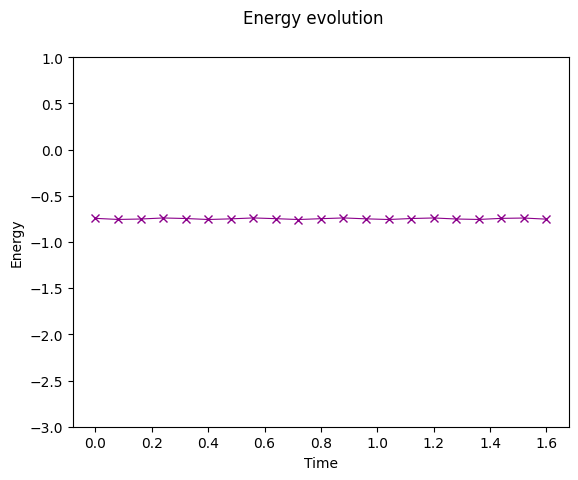

In [345]:
times = np.linspace(0, final_time, num_timesteps + 1) # includes initial state

fig, axes = plt.subplots(1, sharex=True)
axes.plot(times, observables[:, 0], marker='x', label='First order', c='darkmagenta', ls='-', lw=.8)
axes.set_ylabel("Energy")
axes.set_xlabel("Time")
plt.ylim(-3 ,1)
fig.suptitle("Energy evolution")
plt.show()


Let's compare the values we got from Trotter evolution with the exact ones. We'll use the expression we talked about in the introduction.






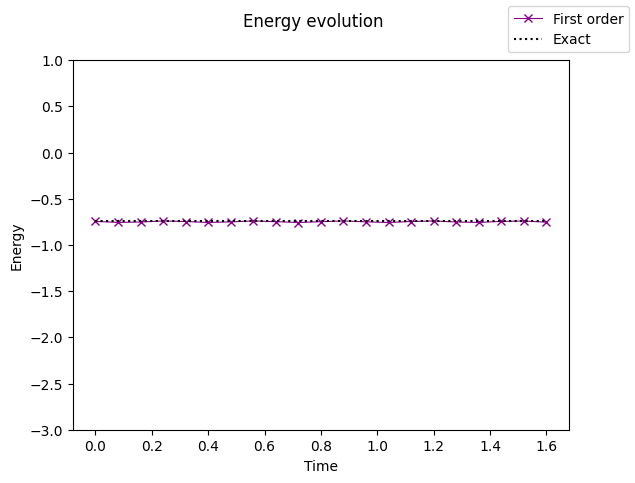

In [346]:
import scipy as sc

H_array = h2_hamiltonian.to_matrix()
exact_times = np.linspace(0, final_time, 101)

# We compute the exact evolution using the exp
exact_evolution = [initial_state.evolve(sc.linalg.expm(-1j * time * H_array)) for time in exact_times]
exact_energy = np.real([sv.expectation_value(h2_hamiltonian) for sv in exact_evolution])
axes.plot(exact_times, exact_energy, c='k', ls=':', label='Exact')
fig.legend()
fig

## Perturbation

To introduce a new dynamic to our system, we will apply a perturbation. In the quantum domain, a perturbation can be represented by an additional term in the Hamiltonian that adds complexity to the system.

The perturbation function we're employing has the form:

$$
H_{\text{perturbation}} = -h \left( \sum_{i=0}^{N-1} \sin(\alpha) Z_i + \cos(\alpha) X_i \right)
$$

where:

- $N$ is the number of qubits in the system.
- $h$ is a scaling factor for the perturbation.
- $\alpha$ is an angle that controls the balance between the $Z$ and $X$ terms in the perturbation.
- $Z_i$ and $X_i$ are the Pauli-Z and Pauli-X matrices operating on the $i$-th qubit, respectively.



In [347]:
from qiskit.quantum_info import SparsePauliOp
from math import pi

In [348]:
def perturbation(N, h, alpha=0):
    Z_tuples = [('Z', [i], -h * np.sin(alpha)) for i in range(0, N)]
    X_tuples = [('X', [i], -h * np.cos(alpha)) for i in range(0, N)]

    hamiltonian = SparsePauliOp.from_sparse_list([*Z_tuples, *X_tuples], num_qubits=N)
    return hamiltonian.simplify()


In [349]:
pert_H = h2_hamiltonian + perturbation(4, 1, alpha=pi/8)

In [350]:
final_time = 10
num_timesteps = 60


#  Create the initial state and the evolution problem
initial_state=Statevector.from_label('1010')
evolution_problem = TimeEvolutionProblem(pert_H, initial_state=initial_state, time=final_time, aux_operators=[pert_H])

# Second and fourth order Trotter formula
second_order_formula = SuzukiTrotter(order=2) 
fourth_order_formula = SuzukiTrotter(order=4)


# Creates a Trotter algorithm and evolves the initial state
trotter1 = TrotterQRTE(num_timesteps=num_timesteps, estimator=Estimator())
trotter2 = TrotterQRTE(num_timesteps=num_timesteps, estimator=Estimator(), product_formula=second_order_formula) 
trotter4 = TrotterQRTE(num_timesteps=num_timesteps, estimator=Estimator(), product_formula=fourth_order_formula)

result1 = trotter1.evolve(evolution_problem)
result2 = trotter2.evolve(evolution_problem)
result4 = trotter4.evolve(evolution_problem)

evo_circuit1 = result1.evolved_state
evo_circuit2 = result2.evolved_state
evo_circuit4 = result4.evolved_state

observables1 = np.array(np.array(result1.observables)[:, :, 0])
observables2 = np.array(np.array(result2.observables)[:, :, 0])
observables4 = np.array(np.array(result4.observables)[:, :, 0])

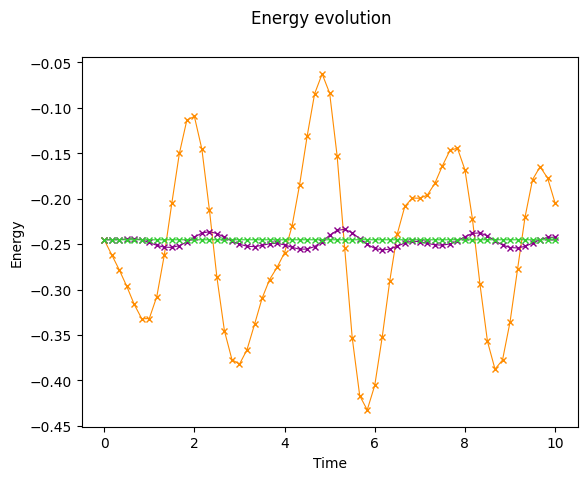

In [351]:
times = np.linspace(0, final_time, num_timesteps + 1) # includes initial state

fig, axes = plt.subplots(1, sharex=True)
axes.plot(times, observables1[:, 0], marker='x',markersize=4, label='First order', c='darkorange', ls='-', lw=.8)
axes.plot(times, observables2[:, 0], marker='x',markersize=4, label='Second order', c='darkmagenta', ls='-', lw=.8)
axes.plot(times, observables4[:, 0], marker='x',markersize=4, label='Fourth order', c='limegreen', ls='-', lw=.8)
axes.set_ylabel("Energy")
axes.set_xlabel("Time")
fig.suptitle("Energy evolution")
plt.show()

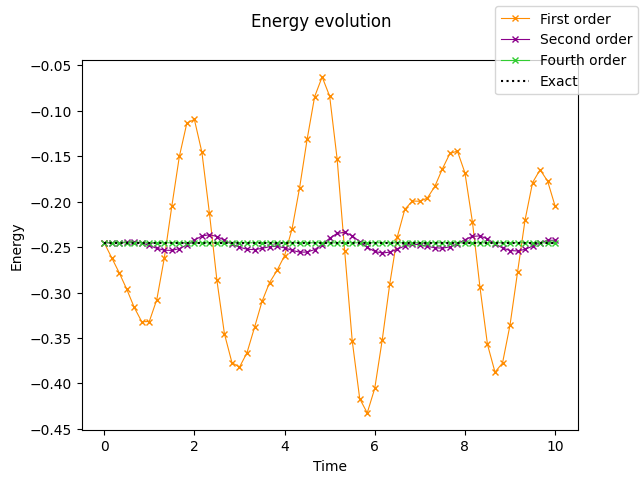

In [352]:
H_array = pert_H.to_matrix()
exact_times = np.linspace(0, final_time, 101)

# We compute the exact evolution using the exp
exact_evolution = [initial_state.evolve(sc.linalg.expm(-1j * time * H_array)) for time in exact_times]
exact_energy = np.real([sv.expectation_value(pert_H) for sv in exact_evolution])
axes.plot(exact_times, exact_energy, c='k', ls=':', label='Exact')
fig.legend()
fig

## Investigating the Effect of Field Direction on $H_2$ Molecule Evolution

We're diving deep into the influence of the field direction on the time evolution of the $H_2$ molecule


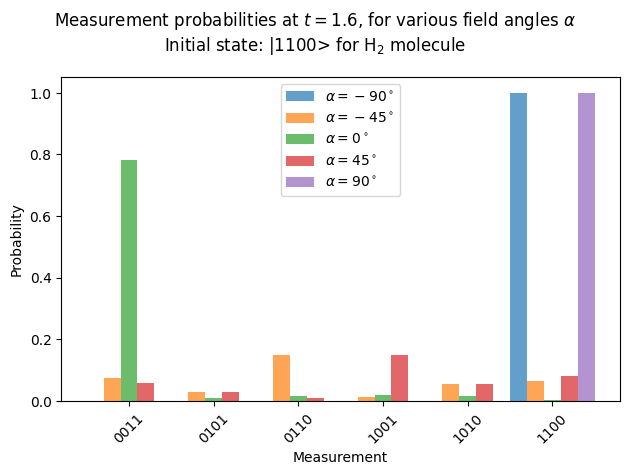

In [353]:
bar_width = .1

initial_state = Statevector.from_label("1100")
final_time = 1.6
eps = 1e-5

alphas = np.linspace(-np.pi/2 + eps, np.pi/2 - eps, 5)
num_alphas = len(alphas)
num_states = 16
bar_positions = np.arange(num_states) * num_alphas * bar_width

# For storing all valid labels encountered over all iterations
all_valid_labels = set()

for i, alpha in enumerate(alphas):
    H_alpha = h2_hamiltonian + perturbation(4, 1, alpha=alpha)
    problem = TimeEvolutionProblem(H_alpha, initial_state=initial_state, time=1.6)
    result = trotter2.evolve(problem)
    evolved_state = Statevector(result.evolved_state)
    
    # Dictionary of probabilities
    amplitudes_dict = evolved_state.probabilities_dict()
    
    # Filtering out the states with two electrons
    valid_keys = [key for key in amplitudes_dict.keys() if sum(map(int, key)) == 2]
    labels = valid_keys
    values = [amplitudes_dict[key] for key in valid_keys]
    
    all_valid_labels.update(labels)  # Add to our global list of valid labels
    
    # Convert angle to degrees
    alpha_str = f"$\\alpha={int(np.round(alpha * 180 / np.pi))}^\\circ$"
    plt.bar(bar_positions[:len(labels)] + i * bar_width, values, bar_width, label=alpha_str, alpha=.7)

# Adjust x-ticks to be centered under the groups of bars
plt.xticks(bar_positions[:len(all_valid_labels)] + (num_alphas - 1) * bar_width / 2, sorted(all_valid_labels), rotation=45)

plt.xlabel("Measurement")
plt.ylabel("Probability")
plt.suptitle(
    f"Measurement probabilities at $t={final_time}$, for various field angles $\\alpha$\n"
    f"Initial state: |1100> for H$_2$ molecule"
)
plt.legend()
plt.tight_layout()
plt.show()

## Time dependent Hamiltonian

### First Draft of a time-dependent hamiltonian

First, we create a time-dependent perturbation to add to our time-independent Hamiltonian.
Then, we nest that within a function which returns our total hamiltonian at '''time delta_t'''
And, we establish our current state as the ground state. 

In [354]:
def t_perturbation(N, h, alpha=0, delta_t=0):
    """
    Parameters
    ----------
    N : int
            Number of qubits
    h : float
            Amplitude of the perturbation
    alpha : float
            Frequency of the perturbation 
    delta_t : float
            The time at which the hamiltonian is to be evaluated.

    Returns
    -------
    QuantumCircuit :
            A quantum circuit containing the Hamiltonian at time delta_t 
    """
    Z_tuples = [('Z', [i], -h * (1/np.exp(delta_t/2))*np.sin(alpha*delta_t)) for i in range(0, N)]
    X_tuples = [('X', [i], -h * (1/np.exp(delta_t/2))*np.cos(alpha*delta_t)) for i in range(0, N)]

    hamiltonian = SparsePauliOp.from_sparse_list([*Z_tuples, *X_tuples], num_qubits=N)
    return h2_hamiltonian + hamiltonian.simplify()

T = 10
n = 1000
delta_t = T/n
observables = []

# Now, we take inspiration from trotterization and create a naive implementation.

If we can time evolve our statevector by creating an evolution operator for every
time, separated by an interval delta_t. Since delta_t is small, this is an effective 
first-order trotterization. So, we simply multiply together all of the evolution operators
to produce our total effect. The assumption here is that the simple matrix exponential is valid
for small delta_t.

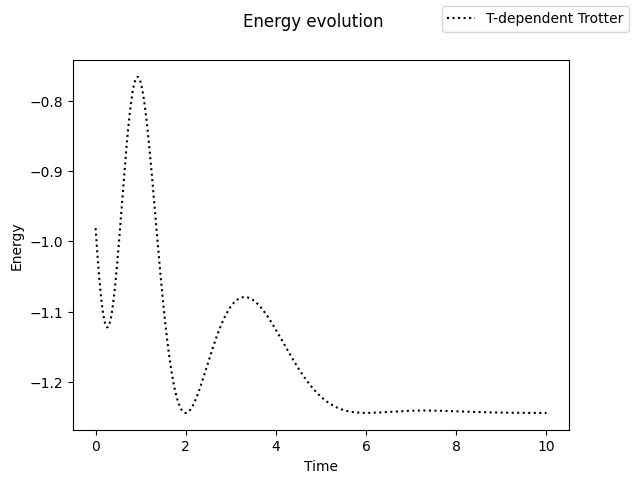

In [355]:
sv = Statevector.from_label("1100")

steps = np.linspace(0, T, n + 1)
t_dep_hamiltonians = [t_perturbation(4, 200, pi/4, step).to_matrix() for step in steps]

delta_t = T/n

#evolve the solution for every discrete interval delta_t
exact_evolution = [initial_state.evolve(sc.linalg.expm(-1j * delta_t * ham_t)) for ham_t in t_dep_hamiltonians]

fig, axes = plt.subplots(1, sharex=True)
# We compute the exact evolution using the exp
exact_energy = np.real([sv.expectation_value(h2_hamiltonian) for sv in exact_evolution])
axes.plot(steps, exact_energy, c='k', ls=':', label='T-dependent Trotter')
axes.set_ylabel("Energy")
axes.set_xlabel("Time")
fig.suptitle("Energy evolution")
fig.legend()
plt.show()

## Adiabatic

To understand the Zeeman magnetic interactions in the context of quantum mechanics, we often consider perturbations applied to electron spins in an external magnetic field.

Consider an external magnetic field $\mathbf{B}$ with components in both the x and z directions. The Zeeman term that accounts for the interactions of electron spins with this external magnetic field is:

$$ H_Z = -g \mu_B \sum_i \mathbf{B} \cdot \mathbf{S_i} $$

Where:
- $g$ is the g-factor (approximately 2 for electrons).
- $\mu_B$ is the Bohr magneton.
- $\mathbf{S_i}$ represents the spin operator for the ith electron.

The z-component of the spin operator $S_z$, in terms of fermionic creation and annihilation operators, is:

$$ S_z = \frac{1}{2} (c_{\uparrow}^\dagger c_{\uparrow} - c_{\downarrow}^\dagger c_{\downarrow}) $$

Similarly, the x-component $S_x$ can be expressed in terms of the fermionic operators as:

$$ S_x = \frac{1}{2} (c_{\uparrow}^\dagger c_{\downarrow} + c_{\downarrow}^\dagger c_{\uparrow}) $$

Incorporating these into the Zeeman Hamiltonian, we get:

$$ H_Z = -g \mu_B \left( B_z \sum_i (c_{i,\uparrow}^\dagger c_{i,\uparrow} - c_{i,\downarrow}^\dagger c_{i,\downarrow}) + B_x \sum_i (c_{i,\uparrow}^\dagger c_{i,\downarrow} + c_{i,\downarrow}^\dagger c_{i,\uparrow}) \right) $$

This equation captures the Zeeman interactions of electron spins with an external magnetic field that has components in both x and z directions. If there are magnetic field components in the y direction, additional terms involving $S_y$ would need to be incorporated.


In [356]:
def mf_hamiltonian(Bx, By, Bz): 
    g = 2  # gyromagnetic ratio
    mu_B = 1 # 5.7883818012e-5  # Bohr magneton in eV/T

    num_orbitals = molecule.num_spatial_orbitals
    terms = []

    for i in range(num_orbitals):
        # Z-Component
        up_term_z = FermionicOp(f"+_{2*i} -_{2*i}")
        down_term_z = FermionicOp(f"+_{2*i+1} -_{2*i+1}")
        terms.append(Bz * 0.5 * (up_term_z - down_term_z))
        
        # X-Component
        up_down_term_x = FermionicOp(f"+_{2*i} -_{2*i+1}")
        down_up_term_x = FermionicOp(f"+_{2*i+1} -_{2*i}")
        terms.append(Bx * 0.5 * (up_down_term_x + down_up_term_x))
        
        # Y-Component
        up_down_term_y = 0.5j*FermionicOp(f"+_{2*i} -_{2*i+1}")
        down_up_term_y = -0.5j*FermionicOp(f"+_{2*i+1} -_{2*i}")
        terms.append(By * (up_down_term_y + down_up_term_y))

    return -g * mu_B * sum(terms)

z_hamiltonian = mapper.map(mf_hamiltonian(0,0,1))
x_hamiltonian = mapper.map(mf_hamiltonian(1,0,0))
y_hamiltonian = mapper.map(mf_hamiltonian(0,1,0))

In [357]:
def perturbated_h(hx,hz,t, tau):
    return  h2_hamiltonian + (1-t/tau)*hx*x_hamiltonian+ t/tau*hz*z_hamiltonian

In [358]:
def simulate(hx, hz, tau, delta_t, steps,):
    eigenvalues, eigenvectors = np.linalg.eig(perturbated_h(hx, hz,0,tau).to_matrix())
    # Get the index of the smallest eigenvalue (i.e., the ground state energy)
    ground_state_idx = np.argmin(eigenvalues)
    current_state = eigenvectors[:, ground_state_idx]

    ground_state_vector = np.ascontiguousarray(eigenvectors[:, ground_state_idx])
    current_state = Statevector(ground_state_vector)


    observables = []
    observables2 = []
    observables3 = []
    observables4 = []
    t_dep_hamiltonians = [perturbated_h(hx,hz, step, tau) for step in steps]

    #evolve the solution for every discrete interval delta_t
    for ham_t in t_dep_hamiltonians:
        current_state = Statevector(current_state.evolve(sc.linalg.expm(-1j * delta_t * ham_t)))
        observables.append(current_state.expectation_value(ham_t).real)
        observables2.append(current_state.expectation_value(perturbated_h(hx,hz,tau, tau)).real)
        observables3.append(current_state.expectation_value(perturbated_h(hx,hz,0,tau)).real)
        observables4.append(min(np.linalg.eigvals(ham_t.to_matrix())).real)

    return observables, observables2, observables3, observables, current_state

In [359]:
def plot_results(observables, observables2, observables3, observables4, exact_initial_energy,exact_final_energy, steps):
    fig, axes = plt.subplots(1, sharex=True)

    # We compute the exact evolution using the exp
    axes.plot(steps, observables, c='k', ls=':', label='H(t)', lw = 2)
    axes.plot(steps, observables2, c='g', ls=':', label='Final Hamiltonian')
    axes.plot(steps, observables3, c='r', ls=':', label='Initial Hamiltonian')
    plt.axhline(y=exact_final_energy, color='g', linestyle='-', label='Final Energy', )
    plt.axhline(y=exact_initial_energy, color='r', linestyle='-', label='Initial Energy')
    plt.legend()
    axes.set_ylabel("Energy")
    axes.set_xlabel("Time")
    fig.suptitle("Energy evolution")
    plt.show()

In [360]:
tau  = 10000
hz = 80
hx = hz
delta_t = 1
steps = np.linspace(0, tau, 1000)
observables1, observables2, observables3,observables4, current_state = simulate(hx, hz, tau, delta_t,steps)
exact_final_energy = min(np.linalg.eigvals(perturbated_h(hx,hz,tau, tau)).real)
exact_initial_energy = min(np.linalg.eigvals(perturbated_h(hx,hz,0,tau).to_matrix()).real)

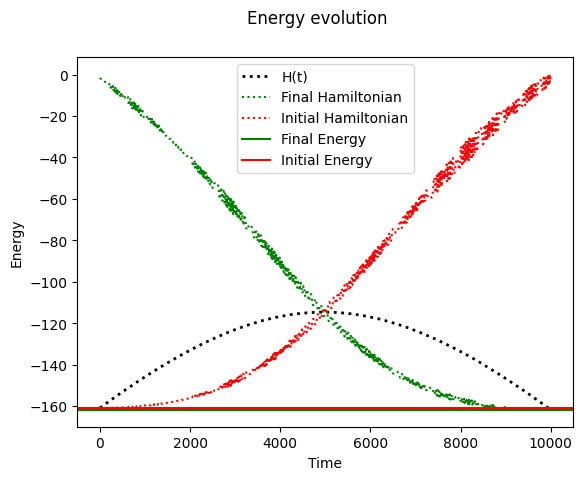

In [361]:
plot_results(observables1, observables2, observables3,observables4, exact_initial_energy, exact_final_energy, steps)

In [362]:
tau  = 250
hz = 0.5
hx = hz
delta_t = 1
steps = np.linspace(0, tau, tau)
observables1, observables2, observables3, observables4, current_state = simulate(hx, hz, tau, delta_t,steps)
exact_final_energy = min(np.linalg.eigvals(perturbated_h(hx,hz,tau, tau)).real)
exact_initial_energy = min(np.linalg.eigvals(perturbated_h(hx,hz,0,tau).to_matrix()).real)

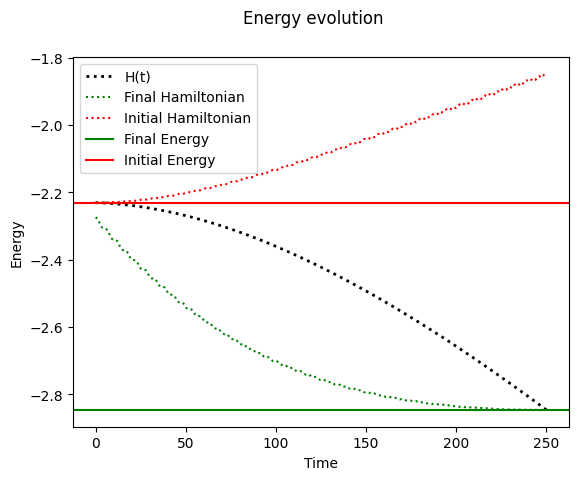

In [363]:
plot_results(observables1, observables2, observables3,observables4, exact_initial_energy, exact_final_energy, steps)